In [1]:
# from pyeeg.connectivity import phase_transfer_entropy
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import pandas as pd

In [2]:
fs = 100
t = np.arange(0, 10, 1/fs)
x = np.random.randn(len(t), 1)
low_pass = sig.firwin(101, 10, fs=fs) # 10 Hz low pass filter
x = sig.filtfilt(low_pass, 1, x, axis=0)

In [3]:
plt.style.use('my_dark')

(0.0, 50.0)

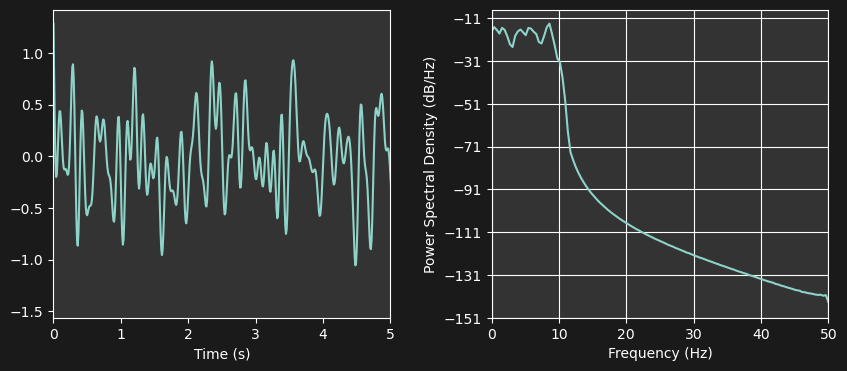

In [4]:
f, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
ax[0].plot(t, x)
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim([0, 5])

ax[1].psd(x.squeeze(), Fs=fs) # power spectral density
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_xlim([0, 50])

In [5]:
phi_x = np.angle(sig.hilbert(x, axis=0)) # between -pi and pi

(0.0, 5.0)

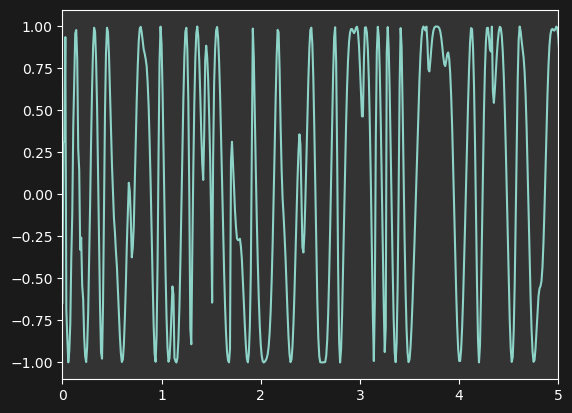

In [6]:
plt.plot(t, np.sin(phi_x))
plt.xlim([0, 5])

## Granger Causality

Focusing on:
1. Granger causality defined from autoregressive methods (see [Cohen's video](https://www.youtube.com/watch?v=XqsSB_vpHLs))
2. Compared to spectral measures such as magnitude coherence between both signals

First I need to produce two signals from a VAR model:
- I will either generate one $X\approx$ AR(2)/ or $\approx \mathcal{N}(0, 1)$ signal, and bind a second signal to it such as e.g. $Y(t) = 1.2 X(t-1) - 0.9 X(t-2)$
- or directly generate a _pair_ of signals with a VAR(2) model

Given the univariate process:
$$
x(t) = a_1 x(t-1) + a_2 x(t-2) + \cdots + e_{x}(t)
$$
And the bivariate process:
$$
x(t) = a_1 x(t-1) + a_2 x(t-2) + \cdots + b_1 y(t-1) + b_2 y(t-2) + \cdots +  \epsilon_{xy}(t)
$$

We can get the granger causality measure as:
$$
GC = log(\frac{var(e)}{var(\epsilon)})
$$

In [287]:
import statsmodels.tsa.api as smt

def simulate_ar(order, coefs, n, sigma=1):
    """
    Simulate an autoregressive process of order `order`.

    Parameters
    ----------
    order : int
        The order of the autoregressive process.
    coefs : array_like
        The coefficients of the autoregressive process. The first element is the coefficient of the lag (t-1).
    n : int
        The number of samples to simulate.
    sigma : float
        The standard deviation of the additive noise process.
    
    Returns
    -------
    x : array_like
        The simulated time series. Shape (n,).
    """
    x = np.zeros(n + order)
    for i in range(n+order):
        if i < order:
            x[i] = np.random.randn()* sigma
        else:
            x[i] = np.dot(coefs[::-1], x[i-order:i]) + np.random.randn()*sigma
    return x[order:]

# Function to simulate VAR model
def simulate_var(order, coef, nobs, ndim=2, rng=np.random.default_rng(42), verbose=False):
    """
    Simulate a VAR model of order `order`.

    The VAR model is defined as:

    .. math::
        x_t = A_1 x_{t-1} + A_2 x_{t-2} + ... + A_p x_{t-p} + \\epsilon_t
        x_t = \\sum_{i=1}^p A_i x_{t-i} + \\epsilon_t

    where :math:`x_t` is a vector of shape (ndim, 1), :math:`A_i` is a matrix of shape (ndim, ndim)

    .. note::
        The coefficients at a given lag are such as :math:`C_ij` is i->j, so it will be the coefficients for dimension j!
        For example, each row of the first column are determining the contributions of each component onto the first component.
    """
    if isinstance(rng, int):
        rng = np.random.default_rng(rng)
    if order == 1 and coef.ndim == 2:
        coef = coef[None, :, :]
    assert coef.shape == (order, ndim, ndim), "coef must be of shape (order, ndim, ndim)"
    data = np.zeros((nobs, ndim))

    if verbose:
        print(f"Simulating VAR({order}) model with {ndim} dimensions and {nobs} observations")
        print(f"Data shape: {data.shape}")

    noise = rng.normal(size=(nobs, ndim))
    data = noise.copy()
    # TODO: This can be vectorized
    for t in range(order, nobs):
        for lag in range(order):
            data[t] += data[t-(lag+1)] @ coef[lag] # here if I multiply from the left, I get the contributions row wise instead of column wise

    # Vectorized version
    data2 = noise.copy()
    for lag in range(order):
        data2[lag+1:] += data2[:nobs-(lag+1)] @ coef[lag] # here if I multiply from the left, I get the contributions row wise instead of column wise
    print(np.allclose(data, data2))
    return data, data2

def fit_ar(x, nlags=1, time_axis=0):
    """
    Fit an autoregressive model to a time series.
    This is a helper function for autoregressive models estimation.

    If fed with a multidimensional time series, it will fit a model for each
    dimension.
    """
    if x.ndim == 1:
        time_axis = 1
    x = np.atleast_2d(x)
    if time_axis == 1: # transpose if time is in columns
        x = x.T
    n, k = x.shape # n: number of observations, k: number of dimensions

    X = design_lagmatrix(x, nlags=nlags, time_axis=0) # time axis was already transposed
    if k == 1:
        X = np.atleast_3d(X)
    Y = x[nlags:, :]

    betas = np.zeros((k, nlags))
    for i in range(k):
        betas[i] = np.linalg.lstsq(X[:, :, i], Y[:, i], rcond=None)[0]
    return betas.squeeze() if k==1 else betas

def design_lagmatrix(x, nlags=1, time_axis=0):
    """
    Design a matrix of lagged time series.
    This is a helper function for autoregressive models estimation
    """
    if x.ndim == 1:
        time_axis = 1
    x = np.atleast_2d(x)
    if time_axis == 1: # transpose if time is in columns
        x = x.T
    n, k = x.shape # n: number of observations, k: number of dimensions
    X = np.zeros((n-nlags, nlags, k))
    for i in range(nlags):
        # X[:, i, :] = x[i+1:n-nlags+i+1]
        X[:, i, :] = np.roll(x, (i+1), axis=0)[nlags:, :]
    return X.squeeze(-1) if k==1 else X

def log_likelihood_lm(y, X, beta):
    """
    Compute the log likelihood of a linear model given the data and the parameters.

    Parameters
    ----------
    y : array_like
        The dependent variable. Shape (n, k), with n number of samples.
    X : array_like
        The independent variables. Shape (n, p), with p number of predictors.
    beta : array_like
        The parameters of the model. Shape (p, k), with k number of dependent variables.

    """
    n = len(y)
    residuals = y - X @ beta
    sigma2 = np.var(residuals, axis=0)
    log_likelihood = -n/2 * np.log(2*np.pi) - n/2 * np.log(sigma2) - 1/(2*sigma2) * np.sum(residuals.T @ residuals, axis=0)
    return log_likelihood

In [ ]:
X = design_lagmatrix(x, nlags=2)
%timeit beta = np.linalg.lstsq(X, x[2:, None], rcond=None)[0]
%timeit beta2 = smt.AutoReg(np.c_[x], 2, 'n').fit().params[:]

beta = beta.squeeze()
beta2 = beta2.squeeze()
data = {'Hand-Built AutoReg': beta, 'Statsmodel AutoReg': beta2}
df = pd.DataFrame(data, index=[f'Coefficient {i}' for i in range(len(beta))])

df

35.2 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.9 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Hand-Built AutoReg,Statsmodel AutoReg
Coefficient 0,1.207431,1.207431
Coefficient 1,-0.827280,-0.827280


In [232]:
X = design_lagmatrix(x, nlags=2, time_axis=0)

In [252]:
log_likelihood_lm(x[2:], X, beta), log_likelihood(x[2:], X, beta)

0.956781843809167


(-1394.8518688579318, -1394.8518688579318)

The results are indeed identical to the ones obtained with the `statsmodels` package. However I did manage to get to this result roughly **60 times** faster!

(0.0, 5.0)

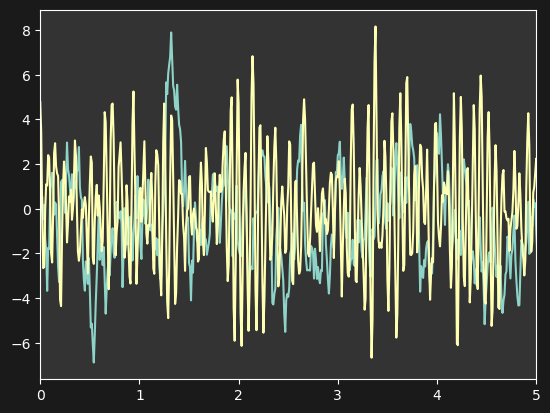

In [143]:
# Example
order = 1
a = np.array([0.9])
n = len(t)
x1 = simulate_ar(order, a, n)
order = 2
a = np.array([1.2, -0.8])
x2 = simulate_ar(order, a, n)
plt.plot(t, x1)
plt.plot(t, x2)
plt.xlim([0, 5])

In [147]:
x = x2
y = np.random.randn(len(t),)
a = [1.05, -0.6]
for k, aa in enumerate(a): # len(a) = order
    y[k+1:] += aa * x[:-k-1] # x[t-k-1]

# Fit AR model
model = smt.AutoReg(np.c_[x], 2)
results = model.fit()
ex = results.resid

# Fit AR model
model = smt.AutoReg(np.c_[y], 2)
results = model.fit()
ey = results.resid

# Fit VAR model
model = smt.VAR(np.c_[x, y])
results = model.fit(maxlags=2)
epsxy = results.resid

In [82]:
GC_xy = np.log(np.var(ey)/np.var(epsxy[:, 0]))
GC_yx = np.log(np.var(ex)/np.var(epsxy[:, 1]))

print(GC_xy, GC_yx)

1.0566728169589346 -0.005752619441728657


In [288]:
nobs = 1000
order = 1
coef = np.diag(np.array([0.8, -0.4])) # as such the coefficients will only influence themselves
coef = np.array([[0.8, -0.2],
                 [0.5, -0.4]])

# Generate data
data, d2 = simulate_var(order, coef, nobs, verbose=True)

Simulating VAR(1) model with 2 dimensions and 1000 observations
Data shape: (1000, 2)
False


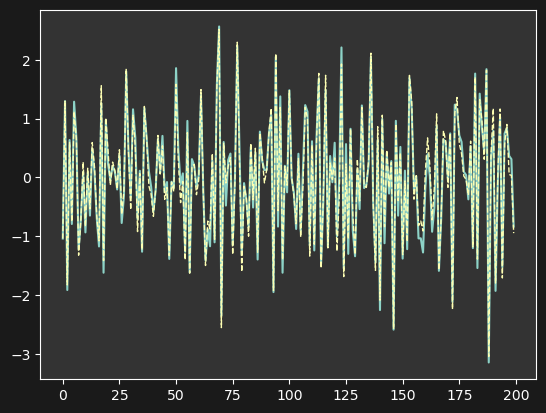

In [299]:
plt.plot(data[:200, 1])
plt.plot(d2[:200, 1], lw=1, ls='--')

In [304]:
print(data[0], d2[0])
print(coef @ data[0], coef @ d2[0])
print(data[0] @ coef, d2[0] @ coef)
print(data[1], d2[1])
print(data[2], d2[2])
print(data[3], d2[3])

[ 0.30471708 -1.03998411] [ 0.30471708 -1.03998411]
[0.45177049 0.56835218] [0.45177049 0.56835218]
[-0.27621839  0.35505023] [-0.27621839  0.35505023]
[0.47423281 1.29561494] [0.47423281 1.29561494]
[-0.92384147 -1.91527205] [-0.88039187 -1.82849563]
[-1.5688688   0.63463452] [-2.0840775   0.59483625]


In [300]:
# Define parameters
nobs = 1000
order = 1
coef = np.diag(np.array([0.8, -0.4])) # as such the coefficients will only influence themselves
coef = np.array([[0.8, -0.2],
                 [0.5, -0.4]])

# Generate data
# data = simulate_var(order, coef, nobs)

# Fit VAR model
model = smt.VAR(data)
results = model.fit(maxlags=order)

# Print model summary
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Nov, 2023
Time:                     13:10:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0429121
Nobs:                     999.000    HQIC:                 0.0246433
Log likelihood:          -2835.75    FPE:                    1.01353
AIC:                    0.0134421    Det(Omega_mle):         1.00747
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.065970         0.031972           -2.063           0.039
L1.y1         0.819524         0.019528           41.967           0.000
L1.y2         0.524012         0.028834           18.174           0.000

Results for equation 

In [301]:
print(results.coefs) # coefs
#results.resid_acov(2)
results.resid.shape # residual for each time series (epsilon as we doing a multivariate regression)

[[[ 0.81952445  0.52401185]
  [-0.21859372 -0.400867  ]]]


(999, 2)

In [302]:
results.resid_acov(0), results.resid_corr

(array([[[0.98124527, 0.05824476],
         [0.05824476, 1.024029  ]]]),
 array([[1.        , 0.05810479],
        [0.05810479, 1.        ]]))

In [303]:
results.test_causality(1, 0, kind='f').summary()

Test statistic,Critical value,p-value,df
120.1,3.846,0.000,"(1, 1992)"


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: y1 does not Granger-cause y2: reject at 5% significance level. Test statistic: 724.035, critical value: 3.846>, p-value: 0.000>
(33,)
(33,)


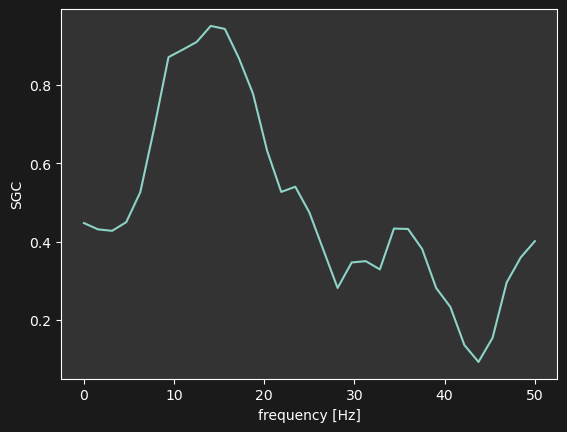

In [116]:
# data = np.c_[x, y]

# Assume data is your two-dimensional time series data
model = smt.VAR(data)
results = model.fit(maxlags=1)

# Test for Granger Causality
# granger_test = results.test_causality('y', 'x', kind='f')
granger_test = results.test_causality(1, 0, kind='f')
print(granger_test)

# Assume x and y are your time series data
x, y = data.T
nfft = 64
f, Pxx = sig.welch(x, nperseg=nfft, window='hann', fs=fs, scaling='spectrum')
# f, Pxx = sig.csd(x, x, fs=fs)
_, Pyy = sig.welch(y, nperseg=nfft, window='hann', fs=fs, scaling='spectrum')
# _, Pyy = sig.csd(y, y)
f2, Pxy = sig.csd(x, y,nperseg=nfft, scaling='spectrum')

print(Pxx.shape)
# print(f)
print(Pxy.shape)

# Compute spectral Granger causality
SGC = np.abs(Pxy)**2 / (Pxx * Pyy)

# Plot spectral Granger causality
# plt.semilogy(f, SGC)
plt.plot(f, SGC)
plt.xlabel('frequency [Hz]')
plt.ylabel('SGC')
plt.show()